In [142]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [143]:
import numpy as np
import pandas as pd

In [144]:
import datetime as dt
from datetime import timedelta

# Reflect Tables into SQLAlchemy ORM

In [145]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine,inspect, func

from sqlalchemy import Table, Column, Integer, String, MetaData, ForeignKey

In [146]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite", echo=False)

In [147]:
# reflect an existing database into a new model
Base = automap_base()

# reflect the tables
Base.prepare(engine, reflect=True)


In [148]:
# We can view all of the classes that automap found
Base.classes.keys()


['measurement', 'station']

In [149]:
# Save references to each table
Measurement = Base.classes.measurement
Station     = Base.classes.station

In [150]:
# get the columns of Measurement
inspector = inspect(engine)
columns = inspector.get_columns('Measurement')
for c in columns:
    print(c['name'], c["type"])


id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [151]:
# get the columns of Station
columns = inspector.get_columns('Station')
for c in columns:
    print(c['name'], c["type"])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [152]:
# Create our session (link) from Python to the DB
session = Session(engine)


# Exploratory Climate Analysis

In [153]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
# Calculate the date 1 year ago from the last data point in the database 
# Perform a query to retrieve the data and precipitation scores 
# Sort the dataframe by date

prcp_last_twelve = engine.execute("Select prcp, date from Measurement where date >="
                                          "(Select strftime('%Y-%m-%d',max(m.date),'-12 month') from Measurement m)"
                                  "order by date desc"
                                ).fetchall()

prcp_last_twelve

[(0.0, '2017-08-23'),
 (0.0, '2017-08-23'),
 (0.08, '2017-08-23'),
 (0.45, '2017-08-23'),
 (0.0, '2017-08-22'),
 (0.0, '2017-08-22'),
 (0.5, '2017-08-22'),
 (0.0, '2017-08-21'),
 (0.02, '2017-08-21'),
 (None, '2017-08-21'),
 (0.56, '2017-08-21'),
 (0.0, '2017-08-20'),
 (0.01, '2017-08-20'),
 (None, '2017-08-20'),
 (0.0, '2017-08-19'),
 (0.0, '2017-08-19'),
 (None, '2017-08-19'),
 (0.09, '2017-08-19'),
 (0.0, '2017-08-18'),
 (0.0, '2017-08-18'),
 (0.06, '2017-08-18'),
 (None, '2017-08-18'),
 (0.0, '2017-08-17'),
 (0.05, '2017-08-17'),
 (0.01, '2017-08-17'),
 (0.13, '2017-08-17'),
 (0.0, '2017-08-16'),
 (0.07, '2017-08-16'),
 (0.12, '2017-08-16'),
 (0.42, '2017-08-16'),
 (0.02, '2017-08-15'),
 (0.0, '2017-08-15'),
 (0.06, '2017-08-15'),
 (0.32, '2017-08-15'),
 (0.42, '2017-08-15'),
 (0.0, '2017-08-14'),
 (0.01, '2017-08-14'),
 (0.08, '2017-08-14'),
 (0.0, '2017-08-14'),
 (0.22, '2017-08-14'),
 (0.0, '2017-08-13'),
 (None, '2017-08-13'),
 (0.0, '2017-08-13'),
 (0.0, '2017-08-13'),
 (None,

In [154]:
# Save the query results as a Pandas DataFrame and set the index to the date column
dflast_twelve = pd.DataFrame(prcp_last_twelve, columns=['prcp', 'date'])
dflast_twelve.set_index('date', inplace=True, )
dflast_twelve.head()

,prcp
date,
2017-08-23,0.00
2017-08-23,0.00
2017-08-23,0.08
2017-08-23,0.45
2017-08-22,0.00


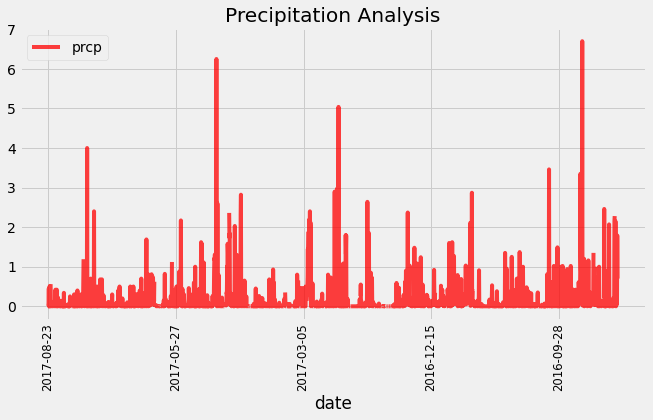

In [155]:
# Use Pandas Plotting with Matplotlib to plot the data

dflast_twelve.plot(title="Precipitation Analysis", figsize=(10,5), color = 'red', alpha = 0.75)

plt.xticks(rotation = 90,horizontalalignment="center",fontsize='small')
# plt.savefig('../Images/PrecipitationAnalysis.png')
plt.show()

In [156]:
# Use Pandas to calcualte the summary statistics for the precipitation data
dflast_twelve.describe()

,prcp
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


## Station Analysis

In [157]:
# Design a query to show how many stations are available in this dataset?
stations = session.query(Measurement.station).distinct().count()

print(f'{stations} stations are available in this dataset')

9 stations are available in this dataset


In [158]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
Stations = session.query(Measurement.station, func.count(Measurement.station)).\
           group_by(Measurement.station).order_by(func.count(Measurement.station).desc()).all()

Stations

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [159]:
# getting the most active station into a variable
Stations_df = pd.DataFrame(Stations, columns=['station', 'count'])
most_active = Stations_df['count'].max()
most_active_station = Stations_df.loc[Stations_df['count'] == most_active]['station'].to_list()
print(f'The station with the highest number of observation is {most_active_station[0]}')

The station with the highest number of observation is USC00519281


In [160]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?
temp_data = session.query(func.min(Measurement.tobs), func.max(Measurement.tobs),func.avg(Measurement.tobs)).\
               filter(Measurement.station == most_active_station[0]).all()
temp_data

[(54.0, 85.0, 71.66378066378067)]

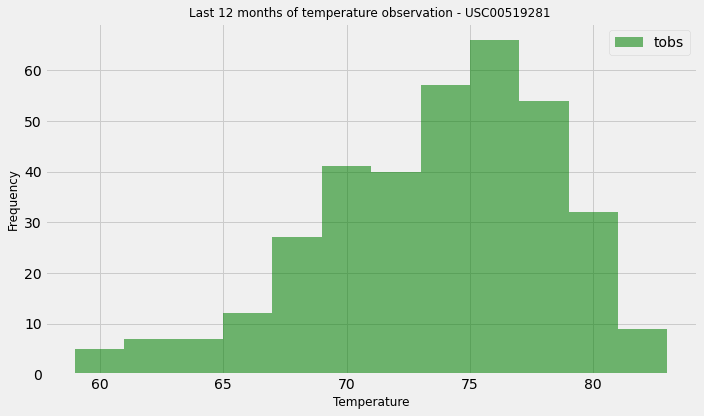

In [161]:
# Choose the station with the highest number of temperature observations.

# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

temp_obs = engine.execute("Select mt.tobs, mt.date "
                          "from Measurement mt "
                          "where mt.station = 'USC00519281' "
                          "and mt.date >="
                                          "(Select strftime('%Y-%m-%d',max(m.date),'-12 month') "
                                             "from Measurement m "
                                            "where m.station = 'USC00519281' )"
                          "order by mt.date asc").fetchall()



temp_obs_df= pd.DataFrame(temp_obs,columns=['tobs','date'])

temp_obs_df.plot.hist(color='green', figsize=[10, 6], bins = 12, alpha = 0.55)

# labels and title
plt.ylabel("Frequency",fontsize=12)
plt.xlabel("Temperature",fontsize=12)
plt.title ('Last 12 months of temperature observation - USC00519281 ', fontsize = 12)
plt.tight_layout()
# plt.savefig('../Images/TempObservation.png')
plt.show()





## Bonus Challenge Assignment

In [162]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
       
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [163]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.

date_data_list_se = []
   
date_data_se = calc_temps('2017-08-16', '2017-08-20')

date_data_list_se = ({'MinimumTemperature':date_data_se[0][0]},
                      {'Average Temperature':date_data_se[0][1]},
                      {'Maximum Temperature':date_data_se[0][2]})

print(calc_temps('2017-08-16', '2017-08-20'))

[(71.0, 78.05263157894737, 85.0)]


Text(0, 0.5, 'Temp (F)')

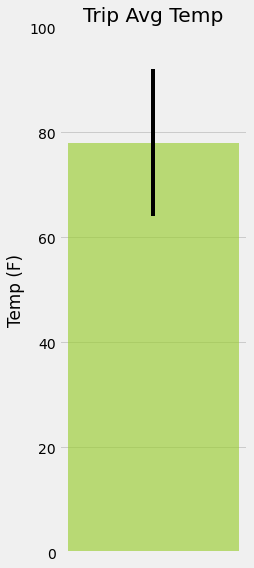

In [164]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)

Min_Temp = date_data_se[0][0]
Avg_Temp = date_data_se[0][1]
Max_Temp = date_data_se[0][2]

plt.figure(figsize=(3,9))
plt.bar(0,Avg_Temp,yerr=[Max_Temp-Min_Temp], color = 'yellowgreen', alpha = 0.65)
plt.ylim(0, 100)
plt.xticks([])
plt.title('Trip Avg Temp')
plt.ylabel('Temp (F)')


In [167]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation

start_date = '2017-08-16'
end_date   = '2017-08-20'

total_rainfall = session.query(Station.station,Station.name,func.sum(Measurement.prcp),
Station.latitude,Station.longitude,Station.elevation)\
.filter(Measurement.station == Station.station).filter(Measurement.date >= start_date)\
.filter(Measurement.date <= end_date)\
.group_by(Station.station)\
.order_by(func.sum(Measurement.prcp).desc()).all()


total_rainfall_df = pd.DataFrame(np.array(total_rainfall))

total_rainfall_d = pd.DataFrame({'Station':total_rainfall_df[0],
                                 'Station Name':total_rainfall_df[1],
                                 'Rainfall':total_rainfall_df[2],
                                 'Latitude':total_rainfall_df[3],
                                 'Longitude':total_rainfall_df[4],
                                 'Elevation':total_rainfall_df[5]
                                })


total_rainfall_d

,Station,Station Name,Rainfall,Latitude,Longitude,Elevation
0,USC00516128,"MANOA LYON ARBO 785.2, HI US",0.64,21.3331,-157.8025,152.4
1,USC00519281,"WAIHEE 837.5, HI US",0.19,21.45167,-157.84888999999998,32.9
2,USC00519523,"WAIMANALO EXPERIMENTAL FARM, HI US",0.12000000000000001,21.33556,-157.71139,19.5
3,USC00514830,"KUALOA RANCH HEADQUARTERS 886.9, HI US",0.01,21.5213,-157.8374,7.0
4,USC00519397,"WAIKIKI 717.2, HI US",0.0,21.2716,-157.8168,3.0
